<a href="https://colab.research.google.com/github/SeanC0112/FridgeImageRecognition/blob/main/FridgeRecipeReccomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing dependencies and basic functions for the Segment Anything model
from https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=c3e9a446-0d12-4b6f-ba93-03fe7453ace7


In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-7nba4r7y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-7nba4r7y
  Resolved https://github.com/facebookresearch/sam2.git to commit 722d1d15111c689908aeeb82d49a57780aac5153
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 626.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.3 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310

In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from google.colab import files

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [ ]:
#function for showing the annotations over the original image
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

Testing the model, code from: https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=ad354922

In [ ]:
#getting my own test image
!wget -P images https://raw.githubusercontent.com/SeanC0112/FridgeImageRecognition/main/fridgeTest.jpg

--2024-12-13 05:44:38--  https://raw.githubusercontent.com/SeanC0112/FridgeImageRecognition/main/fridgeTest.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108583 (106K) [image/jpeg]
Saving to: ‘images/fridgeTest.jpg’

fridgeTest.jpg      100%[===================>] 106.04K  --.-KB/s    in 0.01s   

2024-12-13 05:44:38 (10.1 MB/s) - ‘images/fridgeTest.jpg’ saved [108583/108583]



In [ ]:
#opening the image
image_base = Image.open('images/fridgeTest.jpg')
image = np.array(image_base.convert("RGB"))

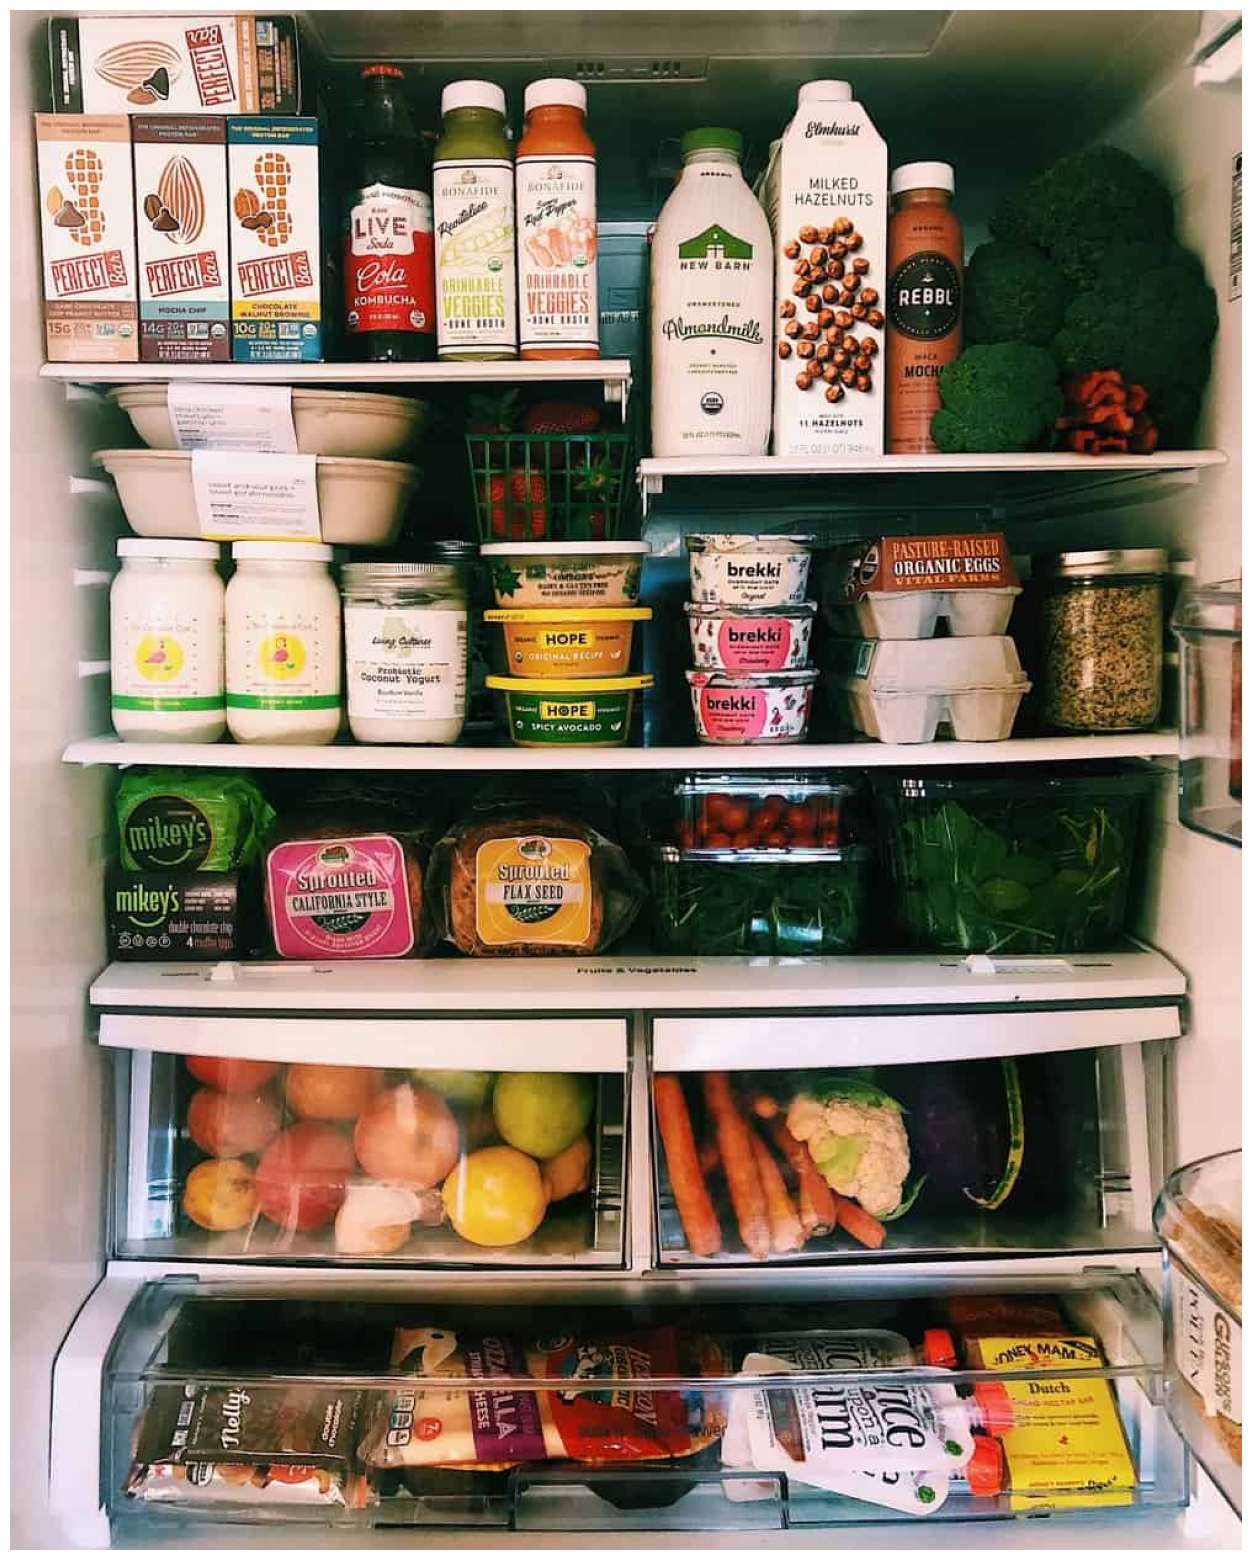

In [ ]:
#showing it using matplotlib
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

Creation of the sam2 model from https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=1848a108

In [ ]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

In [ ]:
#settings for the model, taken from the tutorial
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

Testing the model from https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=fb702ae3

In [ ]:
masks = mask_generator.generate(image)

/usr/local/lib/python3.10/dist-packages/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/usr/local/lib/python3.10/dist-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

Get all the bounding boxes of the masks in the image, written by me

In [ ]:
def get_cropped_images(image, masks):
  bboxes = []
  for mask in masks:
    bboxes.append(mask['bbox'])
    # print(mask['bbox'])
  cropped_images = []
  for bbox in bboxes:
    left = bbox[0]
    right = bbox[0]+bbox[2]
    top = bbox[1]
    bottom = bbox[1]+bbox[3]
    image_cropped = image_base.crop((left, top, right, bottom))
    # image_cropped = np.array(image_cropped.convert("RGB"))
    # plt.figure(figsize=(5, 5))
    # plt.imshow(image_cropped)
    # plt.axis('off')
    # plt.show()
    cropped_images.append(image_cropped)
  return cropped_images

In [ ]:
cropped_images = get_cropped_images(image_base, masks)
# for image_cropped in cropped_images:
#   image_cropped = np.array(image_cropped.convert("RGB"))
#   plt.figure(figsize=(5, 5))
#   plt.imshow(image_cropped)
#   plt.axis('off')
#   plt.show()

text recognition using pytesseract from https://colab.research.google.com/github/bhadreshpsavani/coursera/blob/master/OCRusingTesseract.ipynb

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
import pytesseract

In [ ]:
for cropped_image in cropped_images:
  #tried to conver to BW
  # filter = ImageEnhance.Color(cropped_image)
  # filter.enhance(0)
  cropped_image = ImageOps.grayscale(cropped_image)
  extractedInformation = pytesseract.image_to_string(cropped_image)
  if extractedInformation.upper().isupper():
    print(extractedInformation)
    image_cropped = np.array(cropped_image.convert("RGB"))
    plt.figure(figsize=(5, 5))
    plt.imshow(image_cropped)
    plt.axis('off')
    plt.show()

I tried to do text recognition, but it didn't work that well. I even tried making it black and white, but that didn't help either. I just gave up on it and continued with the image classification model

grabbing a model i made in: https://colab.research.google.com/drive/1YzqURMCAzDTrIc6llroJUk_HiwvbQYxE#scrollTo=qd9Hs56Qudao

In [ ]:
import gdown

url = "https://drive.google.com/drive/folders/17W-KKpmibHU2WAyXPyqdTL1h6hyZ0ri4"
gdown.download_folder(url)

In [ ]:
# importing libraries
import os
import cv2
from tqdm import tqdm
import zipfile
import random
import tensorflow as tf
print(tf.test.gpu_device_name())

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.models import load_model

In [ ]:
#loading the model I made
model = load_model("/content/modelfood/food_recognition_model.keras")


In [ ]:
#all the classes of the model in the correct order
classes = ['alfa-sprouts', 'almonds', 'anchovies', 'aperitif-with-alcohol-aperol-spritz', 'apple', 'apple-crumble', 'apple-pie', 'applesauce-unsweetened-canned', 'apricot-dried', 'apricots', 'artichoke', 'avocado', 'bacon', 'bacon-cooking', 'bacon-frying', 'bacon-raw', 'bagel-without-filling', 'baked-potato', 'balsamic-salad-dressing', 'balsamic-vinegar', 'banana', 'banana-cake', 'basil', 'bean-seeds', 'beans-kidney', 'beans-white', 'beef', 'beef-cut-into-stripes-only-meat', 'beef-filet', 'beef-minced-only-meat', 'beef-roast', 'beef-sirloin-steak', 'beer', 'beetroot-raw', 'beetroot-steamed-without-addition-of-salt', 'bell-pepper-red-raw', 'bell-pepper-red-stewed-without-addition-of-fat-without-addition-of-salt', 'berries', 'birchermuesli-prepared-no-sugar-added', 'biscuit-with-butter', 'biscuits', 'black-forest-tart', 'black-olives', 'blackberry', 'blue-mould-cheese', 'blueberries', 'bolognaise-sauce', 'bouillon', 'bouillon-vegetable', 'bouquet-garni', 'braided-white-loaf', 'brazil-nut', 'bread', 'bread-5-grain', 'bread-black', 'bread-french-white-flour', 'bread-fruit', 'bread-grain', 'bread-half-white', 'bread-meat-substitute-lettuce-sauce', 'bread-nut', 'bread-olive', 'bread-pita', 'bread-rye', 'bread-sourdough', 'bread-spelt', 'bread-ticino', 'bread-toast', 'bread-white', 'bread-whole-wheat', 'bread-wholemeal', 'bread-wholemeal-toast', 'breadcrumbs-unspiced', 'brie', 'brioche', 'broccoli', 'brownie', 'brussel-sprouts', 'buckwheat-grain-peeled', 'buckwheat-pancake', 'bulgur', 'butter', 'butter-herb', 'butter-spread-puree-almond', 'cake-chocolate', 'cake-marble', 'cake-oblong', 'cake-salted', 'cantonese-fried-rice', 'capers', 'cappuccino', 'caprese-salad-tomato-mozzarella', 'carrot-cake', 'carrot-raw', 'carrot-steamed-without-addition-of-salt', 'cashew-nut', 'cauliflower', 'celeriac', 'celery', 'cenovis-yeast-spread', 'cervelat', 'champagne', 'cheddar', 'cheese', 'cheese-for-raclette', 'cheesecake', 'cherries', 'chestnuts', 'chia-grains', 'chicken', 'chicken-breast', 'chicken-curry-cream-coconut-milk-curry-spices-paste', 'chicken-cut-into-stripes-only-meat', 'chicken-leg', 'chicken-nuggets', 'chicken-wing', 'chickpeas', 'chili-con-carne-prepared', 'chinese-cabbage', 'chips-french-fries', 'chives', 'chocolate', 'chocolate-cookies', 'chocolate-egg-small', 'chocolate-filled', 'chocolate-milk-chocolate-drink', 'chocolate-mousse', 'chorizo', 'coca-cola', 'coca-cola-zero', 'cocktail', 'cocoa-powder', 'coconut', 'coconut-milk', 'cod', 'coffee-decaffeinated', 'coffee-with-caffeine', 'coleslaw-chopped-without-sauce', 'cooked-sausage', 'cookies', 'cordon-bleu-from-pork-schnitzel-fried', 'coriander', 'corn', 'corn-crisps', 'corn-flakes', 'cottage-cheese', 'country-fries', 'couscous', 'crackers', 'cream', 'cream-cheese', 'cream-spinach', 'crepe-plain', 'crisp-bread-wasa', 'crisps', 'croissant', 'croissant-wholegrain', 'croissant-with-chocolate-filling', 'croque-monsieur', 'croutons', 'crunch-muesli', 'cucumber', 'cucumber-pickled', 'curd', 'curds-natural-with-at-most-10-fidm', 'curry-vegetarian', 'dairy-ice-cream', 'damson-plum', 'dark-chocolate', 'dates', 'dips', 'dough-puff-pastry-shortcrust-bread-pizza-dough', 'dried-meat', 'dried-raisins', 'dumplings', 'ebly', 'egg', 'egg-scrambled-prepared', 'eggplant', 'eggplant-caviar', 'emmental-cheese', 'espresso-with-caffeine', 'fajita-bread-only', 'falafel-balls', 'faux-mage-cashew-vegan-chers', 'fennel', 'feta', 'fig-dried', 'figs', 'fish', 'fish-crunchies-battered', 'fish-fingers-breaded', 'flakes-oat', 'focaccia', 'fondue', 'french-beans', 'french-pizza-from-alsace-baked', 'french-salad-dressing', 'fresh-cheese', 'fruit-compotes', 'fruit-coulis', 'fruit-salad', 'fruit-tart', 'frying-sausage', 'garlic', 'glucose-drink-50g', 'gluten-free-bread', 'goat-average-raw', 'goat-cheese-soft', 'grapefruit-pomelo', 'grapes', 'greek-salad', 'greek-yaourt-yahourt-yogourt-ou-yoghourt', 'green-asparagus', 'green-bean-steamed-without-addition-of-salt', 'green-olives', 'grissini', 'grits-polenta-maize-flour', 'gruyere', 'guacamole', 'gummi-bears-fruit-jellies-jelly-babies-with-fruit-essence', 'halloumi', 'ham', 'ham-cooked', 'ham-croissant', 'ham-raw', 'ham-turkey', 'hamburger', 'hamburger-bread-meat-ketchup', 'hamburger-bun', 'hard-cheese', 'hazelnut', 'hazelnut-chocolate-spread-nutella-ovomaltine-caotina', 'herbal-tea', 'high-protein-pasta-made-of-lentils-peas', 'honey', 'hummus', 'ice-cubes', 'ice-tea', 'jam', 'juice-apple', 'juice-multifruit', 'juice-orange', 'kaki', 'kebab-in-pita-bread', 'kefir-drink', 'ketchup', 'kiwi', 'kolhrabi', 'lamb', 'lamb-chop', 'lasagne-meat-prepared', 'lasagne-vegetable-prepared', 'latte-macchiato-with-caffeine', 'leaf-spinach', 'leek', 'lemon', 'lemon-cake', 'lemon-pie', 'lentils', 'lentils-green-du-puy-du-berry', 'light-beer', 'linseeds', 'lye-pretzel-soft', 'm-m-s', 'macaroon', 'mandarine', 'mango', 'mango-dried', 'maple-syrup-concentrate', 'margarine', 'mashed-potatoes-prepared-with-full-fat-milk-with-butter', 'mayonnaise', 'meat', 'meat-balls', 'meat-terrine-pate', 'meatloaf', 'meringue', 'milk', 'milk-chocolate', 'milk-chocolate-with-hazelnuts', 'minced-meat', 'mix-of-dried-fruits-and-nuts', 'mixed-nuts', 'mixed-salad-chopped-without-sauce', 'mixed-seeds', 'mixed-vegetables', 'mousse', 'mozzarella', 'muesli', 'muffin', 'mungbean-sprouts', 'mushroom', 'mushroom-average-stewed-without-addition-of-fat-without-addition-of-salt', 'mushrooms', 'mustard', 'mustard-dijon', 'naan-indien-bread', 'nectarine', 'nuts', 'oat-milk', 'oil-vinegar-salad-dressing', 'omelette-plain', 'onion', 'orange', 'pancakes', 'panna-cotta', 'paprika-chips', 'parmesan', 'parsley', 'pasta', 'pasta-hornli', 'pasta-in-butterfly-form-farfalle', 'pasta-in-conch-form', 'pasta-linguini-parpadelle-tagliatelle', 'pasta-noodles', 'pasta-penne', 'pasta-ravioli-stuffing', 'pasta-spaghetti', 'pasta-tortelloni-stuffing', 'pasta-twist', 'pasta-wholemeal', 'pastry-flaky', 'peach', 'peanut', 'peanut-butter', 'pear', 'pearl-onions', 'peas', 'pecan-nut', 'perch-fillets-lake', 'philadelphia', 'pie-apricot-baked-with-cake-dough', 'pie-plum-baked-with-cake-dough', 'pie-rhubarb-baked-with-cake-dough', 'pine-nuts', 'pineapple', 'pistachio', 'pizza-margherita-baked', 'pizza-with-ham-baked', 'pizza-with-ham-with-mushrooms-baked', 'pizza-with-vegetables-baked', 'plums', 'pomegranate', 'popcorn-salted', 'pork', 'pork-chop', 'pork-escalope', 'pork-roast', 'porridge-prepared-with-partially-skimmed-milk', 'potato-gnocchi', 'potato-salad-with-mayonnaise-yogurt-dressing', 'potatoes-au-gratin-dauphinois-prepared', 'potatoes-steamed', 'praline', 'processed-cheese', 'processed-meat-charcuterie', 'prosecco', 'pumpkin', 'pumpkin-seeds', 'quiche-with-cheese-baked-with-puff-pastry', 'quiche-with-spinach-baked-with-cake-dough', 'quinoa', 'raspberries', 'ratatouille', 'red-cabbage', 'red-radish', 'rice', 'rice-basmati', 'rice-jasmin', 'rice-noodles-vermicelli', 'rice-waffels', 'rice-whole-grain', 'rice-wild', 'risotto-with-mushrooms-cooked', 'risotto-without-cheese-cooked', 'ristretto-with-caffeine', 'roll-of-half-white-or-white-flour-with-large-void', 'roll-with-pieces-of-chocolate', 'romanesco', 'rosti', 'rusk-wholemeal', 'salad-dressing', 'salad-lambs-ear', 'salad-leaf-salad-green', 'salad-rocket', 'salami', 'salmon', 'salmon-smoked', 'salt-cake-vegetables-filled', 'sandwich-ham-cheese-and-butter', 'sauce-carbonara', 'sauce-cocktail', 'sauce-cream', 'sauce-curry', 'sauce-mushroom', 'sauce-pesto', 'sauce-roast', 'sauce-savoury', 'sauce-soya', 'sauce-sweet-salted-asian', 'sauce-sweet-sour', 'sauerkraut', 'sausage', 'savoury-puff-pastry', 'savoury-puff-pastry-stick', 'savoy-cabbage-steamed-without-addition-of-salt', 'seeds', 'sekt', 'semi-hard-cheese', 'sesame-seeds', 'shoots', 'shrimp-boiled', 'shrimp-prawn-large', 'shrimp-prawn-small', 'smoked-cooked-sausage-of-pork-and-beef-meat-sausag', 'smoothie', 'soft-cheese', 'sorbet', 'soup-cream-of-vegetables', 'soup-miso', 'soup-of-lentils-dahl-dhal', 'soup-potato', 'soup-pumpkin', 'soup-tomato', 'soup-vegetable', 'sour-cream', 'soya-drink-soy-milk', 'soya-yaourt-yahourt-yogourt-ou-yoghourt', 'spaetzle', 'spinach-raw', 'spinach-steamed-without-addition-of-salt', 'spring-onion-scallion', 'spring-roll-fried', 'strawberries', 'sugar-glazing', 'sugar-melon', 'sun-dried-tomatoe', 'sunflower-seeds', 'sushi', 'sweet-corn-canned', 'sweet-potato', 'sweets-candies', 'swiss-chard', 'syrup-diluted-ready-to-drink', 'taboule-prepared-with-couscous', 'tart', 'tartar-meat', 'tartar-sauce', 'tea', 'tea-black', 'tea-fruit', 'tea-ginger', 'tea-green', 'tea-peppermint', 'tea-rooibos', 'tea-spice', 'tea-verveine', 'tete-de-moine', 'thickened-cream-35', 'tiramisu', 'tofu', 'tomato-raw', 'tomato-sauce', 'tomato-stewed-without-addition-of-fat-without-addition-of-salt', 'tomme', 'tuna', 'tuna-in-oil-drained', 'turnover-with-meat-small-meat-pie-empanadas', 'tzatziki', 'vanille-cream-cooked-custard-creme-dessert', 'veal-sausage', 'vegetable-au-gratin-baked', 'vegetable-mix-peas-and-carrots', 'vegetables', 'veggie-burger', 'waffle', 'walnut', 'water', 'water-mineral', 'water-with-lemon-juice', 'watermelon-fresh', 'white-asparagus', 'white-bread-with-butter-eggs-and-milk', 'white-cabbage', 'white-chocolate', 'white-coffee-with-caffeine', 'white-radish', 'wienerli-swiss-sausage', 'wine-red', 'wine-rose', 'wine-white', 'witloof-chicory', 'yaourt-yahourt-yogourt-ou-yoghourt-natural', 'zucchini', 'zucchini-stewed-without-addition-of-fat-without-addition-of-salt']


In [ ]:
#takes in cropped images and classes, returns the amount of each class that there are in dict
def get_classes(cropped_images, classes):
  classcount = {}
  for cropped_image in cropped_images:
    cropped_image = cropped_image.resize((224,224))
    image_cropped = np.array(cropped_image.convert("RGB"))
    # code to show the images
    plt.figure(figsize=(5, 5))
    plt.imshow(image_cropped)
    plt.axis('off')
    plt.show()
    x = np.expand_dims(image_cropped, axis=0)

    images = np.vstack([x])
    img_classes = model.predict(images, batch_size=10)
    klass = classes[np.argmax(img_classes)]
    print(klass)
    try:
      classcount[klass] += 1
    except:
      classcount[klass] = 1
  return classcount

In [ ]:
# printing the classes from the test image
img_classes = get_classes(cropped_images=cropped_images, classes=classes)
print(img_classes)

One definite flaw of this program is that it will try to classify every image regardless of whether ot not its actually a food. Also, It seems to think everything is water. I now notice that there are significantly more images of water then any other class. I probably should have removed a lot of those before training the model

Testing the whole thing. Upload your own image of a fridge

In [ ]:

# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  image_base = Image.open(path)
  image = np.array(image_base.convert("RGB"))
  #showing it using matplotlib
  plt.figure(figsize=(20, 20))
  plt.imshow(image)
  plt.axis('off')
  plt.show()

#  generating masks
  masks = mask_generator.generate(image)
# showing them
  plt.figure(figsize=(20, 20))
  plt.imshow(image)
  show_anns(masks)
  plt.axis('off')
  plt.show()
  #getting cropped images
  cropped_images = get_cropped_images(image_base, masks)
#getting classes
  img_classes = get_classes(classes=classes, cropped_images=cropped_images)
  print(img_classes)
